In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from numpy import linalg as LA

def twobody(Num,n,U):
    Er = np.eye(2**(Num-2-n))
    El = np.eye(2**n)
    RT = np.kron(U,El)
    Tby = np.kron(Er,RT)
    return Tby

def onebody(Num,n,U):
    RT = np.kron(U,np.eye(2**n))
    Oby = np.kron(np.eye(2**(Num-1-n)),RT)
    return Oby

def shift(Num,n,m,SWAP):
    sym = np.sign(m-n)
    OP = np.eye(2**Num)
    if sym==1:
        st=n
        ed=m
        step=1;
    else:
        st=n-1
        ed=m-1
        step=-1;
    for l in range(st,ed,step):
        OP=np.dot(twobody(Num,l,SWAP),OP)
    return OP

def qubit_state(Num,ind):
    t0 = ind
    d = np.zeros(Num)
    for n in range(Num-1,0,-1):
        d[n] = np.int_(np.floor(t0/(2**n)))
        t0 = t0 - d[n]*2**n
    d[0] = np.remainder(ind,2)
    return d

def eng(Jx,Jz,alpha,kx):
    E = (Jz*alpha + Jx*np.cos(pi*kx))
    return E
    
def gap(Jx,Jz,alpha,kx):
    D = Jx*np.sin(pi*kx)
    return D

def String(Num,n,sig0,sig3):
    OP = 1
    for ns in range(n):
        OP = np.kron(sig3,OP)
    for ns in range(n,Num,1):
        OP = np.kron(sig0,OP)
    return OP

def twooperator(Num,n,m,A,B):  # n<m; A for n; B for m
    opn = np.dot(onebody(Num,n,A),String(Num,n,sig0,sig3))
    opm = np.dot(onebody(Num,m,B),String(Num,m,sig0,sig3))
    OP = np.dot(opn,opm)
    return OP

In [2]:
# useful matrix
sig0=np.array([[1,0],[0,1]])
sig3=np.array([[1,0],[0,-1]])
c = np.array([[0,1],[0,0]]);
cdag = np.matrix.getH(c)
srh = np.sqrt(2)
SWAP = np.array( [[1,0,0,0] , [0,0,1,0] , [0,1,0,0] , [0,0,0,-1]] )
FT = np.array( [[1,0,0,0] , [0,1/srh,1/srh,0] , [0,1/srh,-1/srh,0] , [0,0,0,-1]] )

# matrix relevant to Bogoliubov
def ang(Jx,Jz,alpha,kx):
    eps = eng(Jx,Jz,alpha,kx)
    Del = gap(Jx,Jz,alpha,kx)
    if eps>=0:
        ang = np.arctan(Del/eps)
    else:
        ang = np.arctan(Del/eps) + pi
    return ang

def Bmat(Jx,Jz,alpha,kx):
    ang1 = ang(Jx,Jz,alpha,kx)
    if np.abs(kx) <= 1e-10 or np.abs(kx-1) <= 1e-10:
        B = np.eye(4)
    else:
        B = np.array( [[np.cos(ang1/2),0,0,-1j*np.sin(ang1/2)],[0,1,0,0], 
                  [0,0,1,0],[-1j*np.sin(ang1/2),0,0,np.cos(ang1/2)]] ) 
    return B

Num = 4
def Bog(Jx,Jz,alpha,dk):
    Kp = np.array([0,1])+dk
    M2 = twobody(Num,0,Bmat(Jx,Jz,alpha,Kp[0]))
    M3 = twobody(Num,2,Bmat(Jx,Jz,alpha,Kp[1]))
    BF_OP = np.dot(M3,M2)  
    return BF_OP
    
def FuT(Jx,Jz,alpha,dk):
    # Fourier tensor network
    FTOP = shift(Num,1,2,SWAP)
    FTOP = np.dot(twobody(Num,0,FT),FTOP)
    FTOP = np.dot(twobody(Num,2,FT),FTOP)
    pha = np.kron(np.array([1,-1]),pi*np.arange(2)*dk)
    FOP = np.eye(2**Num)
    for n in range(Num):   # change in full state
        M = np.eye((2),dtype=complex)
        M[1,1] = M[1,1]*np.exp(1j*pha[n])
        FOP = np.dot(onebody(Num,n,M),FOP)
    FTOP = np.dot(FOP,FTOP)
    return FTOP

In [3]:
def UB(qc,angk,q0,q1):
    qc.x(q1)
    qc.cx(q1, q0)
    qc.cu3(angk, pi/2, -pi/2, q0, q1)
    qc.cx(q1, q0)
    qc.x(q1)
    
def fswap(qc,q0,q1):
    qc.swap(q0,q1)
    qc.cz(q0,q1)
    
def UF(qc,q0,q1,dk):
    qc.cx(q1,q0)
    qc.ch(q0,q1)
    qc.cx(q1,q0)
    qc.cz(q0,q1)
    qc.u1(pi*dk,q1)

In [4]:
def ground(Jx,Jz,alpha,dk):
    Kp = np.array([0,1])+dk
    if np.abs(gap(Jx,Jz,alpha,Kp[0])) <= 1e-10:
        Eng1 = eng(Jx,Jz,alpha,Kp[0])
    else:
        Eng1 = np.sqrt(eng(Jx,Jz,alpha,Kp[0])**2+gap(Jx,Jz,alpha,Kp[0])**2)
    if np.abs(gap(Jx,Jz,alpha,Kp[1])) <= 1e-10:
        Eng2 = eng(Jx,Jz,alpha,Kp[1])
    else:
        Eng2 = np.sqrt(eng(Jx,Jz,alpha,Kp[1])**2+gap(Jx,Jz,alpha,Kp[1])**2)
    Ebog = np.array([Eng1,Eng1,Eng2,Eng2])
    sft = np.array([0,-1,0,-1])
    Eb = np.zeros((2**Num),dtype=complex)
    for n in range(2**Num):
        Eb[n] = np.dot(qubit_state(Num,n)+sft,Ebog)+2*Jz*alpha
    ns = np.where(Eb == Eb.min())[0]
    return ns

In [5]:
def measure_coefp(qc, qt, c, Jx,Jz,alpha,dk): # sites 0,1,2,3 test#1
    ns = ground(Jx,Jz,alpha,dk)
    Kp = np.array([0,1])+dk
    Qstate = qubit_state(4,ns)
    # initialize states
    for nq in range(len(Qstate)):
        if Qstate[nq]==1:
            qc.x(qt[nq])
        else:
            pass
    if dk != 0:
        UB(qc,-ang(Jx,Jz,alpha,Kp[0]),qt[0],qt[1])
        UB(qc,-ang(Jx,Jz,alpha,Kp[1]),qt[2],qt[3])
    else:
        pass
    fswap(qc,qt[1],qt[2])
    UF(qc,qt[0],qt[1],dk)
    UF(qc,qt[2],qt[3],dk)
    qc.barrier(qt)
    qc.measure(qt[0], c[0])

In [6]:
def measure_coefm(qc, qt, c, Jx,Jz,alpha,dk): # sites 0,1,2,3 test#1
    ns = ground(Jx,Jz,alpha,dk)
    Kp = np.array([0,1])+dk
    Qstate = qubit_state(4,ns)
    # initialize states
    for nq in range(len(Qstate)):
        if Qstate[nq]==1:
            qc.x(qt[nq])
        else:
            pass
    if dk != 0:
        UB(qc,-ang(Jx,Jz,alpha,Kp[0]),qt[0],qt[1])
        UB(qc,-ang(Jx,Jz,alpha,Kp[1]),qt[2],qt[3])
    else:
        pass
    fswap(qc,qt[1],qt[2])
    UF(qc,qt[0],qt[1],dk)
    UF(qc,qt[2],qt[3],dk)
    qc.barrier(qt)
    qc.measure(qt[2], c[0])

In [7]:
def build_p(Jx,Jz,alpha,dk):
    
    qt = QuantumRegister(4,'sys')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qt, c)
    
    measure_coefp(qc, qt, c, Jx,Jz,alpha,dk)

    return qc

def build_m(Jx,Jz,alpha,dk):
    
    qt = QuantumRegister(4,'sys')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(qt, c)
    
    measure_coefm(qc, qt, c, Jx,Jz,alpha,dk)

    return qc

In [8]:
def circuit_construction(Jx,Jz,alpha,dk):
    circuits = []
    qc = build_p(Jx,Jz,alpha,dk)
    circuits.append(qc)
    qc = build_m(Jx,Jz,alpha,dk)
    circuits.append(qc)
    return circuits

In [10]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.tools.visualization as qkviz
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit import BasicAer

from qiskit import execute, Aer, IBMQ

backend_sim = BasicAer.get_backend('qasm_simulator')

Jz = 1
Jx = 0.5
alpha = -1
klist = np.linspace(-0.5,0.5,21)

nshots=1024*8

AllJobslistp_k=[]
for nk,k in enumerate(klist):
    qc = circuit_construction(Jx,Jz,alpha,k)
#     qobj=qiskit.transpile(qc,backend=backend,initial_layout=[0,1,2,3,4,5,6,7])
    qobj=qiskit.transpile(qc,initial_layout=[0,1,2,3])
    job = qiskit.execute(qobj, backend_sim,shots=nshots)
    AllJobslistp_k.append(job)

In [14]:
def obtain_cm(joblist,nshots):
    result = joblist.result()
    Sz = np.zeros(2)
    for n in range(2):
        num = result.get_counts(n)
        r=list(num.keys())
        a=list(num.values())
        Num_Sta = np.zeros(2)
        coe = np.zeros(2)
        for j in range(0,len(r)):
            label = [ int(s) for s in r[j] ]
            #print(label)
            lab_state = 0
            for m in range(len(label)):
                lab_state = lab_state + 2**m*label[m]
            Num_Sta[lab_state] = a[j]/nshots
            coe[lab_state] =(-1)**(label[0])
        Sz[n] = np.dot(coe,Num_Sta)
    return Sz

def entangle_eig(Elemt):
    CM = np.array([[0,Elemt],[-Elemt,0]])
    v, w = LA.eig(CM)
    idx = v.argsort()[::-1] 
    v = v[idx]
    Rv=np.real(v)/2+1/2
    return Rv

In [12]:
Eeig_cit_pk = np.zeros((2,len(klist)))
Eeig_ext_pk = np.zeros((2,len(klist)))
for nk,k in enumerate(klist):
    joblist = AllJobslistp_k[nk]
    cm = obtain_cm(joblist,nshots)
    Eeig_cit_pk[:,nk] = entangle_eig(np.sum(cm)/2*1j)
    Kp = np.array([0,1]) + k
    exa = np.cos(ang(Jx,Jz,alpha,Kp[0]))/2+np.cos(ang(Jx,Jz,alpha,Kp[1]))/2
    Eeig_ext_pk[:,nk] = entangle_eig(np.real(exa)*1j)

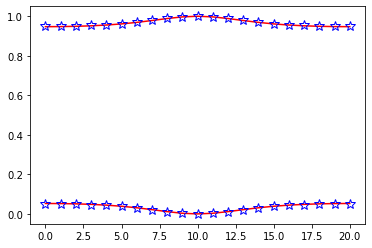

In [13]:
plt.plot(np.transpose(Eeig_ext_pk),'r-',markersize=8)
plt.plot(np.transpose(Eeig_cit_pk),'b*',markerfacecolor='None',markersize=10)

In [14]:
Jz = 1
Jx = 1.5
alpha = -1
klist = np.linspace(-0.5,0.5,21)

nshots=1024*8

AllJobslistm_k=[]
for nk,k in enumerate(klist):
    qc = circuit_construction(Jx,Jz,alpha,k)
#     qobj=qiskit.transpile(qc,backend=backend,initial_layout=[0,1,2,3,4,5,6,7])
    qobj=qiskit.transpile(qc,initial_layout=[0,1,2,3])
    job = qiskit.execute(qobj, backend_sim,shots=nshots)
    AllJobslistm_k.append(job)

In [15]:
Eeig_cit_mk = np.zeros((2,len(klist)))
Eeig_ext_mk = np.zeros((2,len(klist)))
for nk,k in enumerate(klist):
    joblist = AllJobslistm_k[nk]
    cm = obtain_cm(joblist,nshots)
    Eeig_cit_mk[:,nk] = entangle_eig(np.sum(cm)/2*1j)
    Kp = np.array([0,1]) + k
    exa = np.cos(ang(Jx,Jz,alpha,Kp[0]))/2+np.cos(ang(Jx,Jz,alpha,Kp[1]))/2
    Eeig_ext_mk[:,nk] = entangle_eig(np.real(exa)*1j)

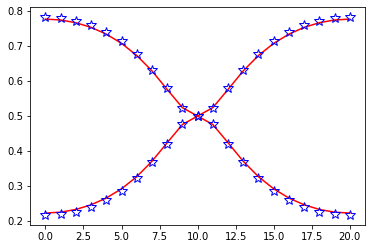

In [16]:
plt.plot(np.transpose(Eeig_ext_mk),'r-',markersize=8)
plt.plot(np.transpose(Eeig_cit_mk),'b*',markerfacecolor='None',markersize=10)

In [11]:
Jz = 1
alpha = -1
k = 0
Jlist = np.linspace(0.01,2.01,11)

nshots=1024*8

AllJobslist_Jx=[]
for nj,J in enumerate(Jlist):
    qc = circuit_construction(J,Jz,alpha,k)
#     qobj=qiskit.transpile(qc,backend=backend,initial_layout=[0,1,2,3,4,5,6,7])
    qobj=qiskit.transpile(qc,initial_layout=[0,1,2,3])
    job = qiskit.execute(qobj, backend_sim,shots=nshots)
    AllJobslist_Jx.append(job)

In [12]:
def findS(Elemt):
    CM = np.array([[0,Elemt],[-Elemt,0]])
    v, w = LA.eig(CM)
    idx = v.argsort()[::-1] 
    v = v[idx]
    Rv=np.real(v)/2+1/2
    nv = len(Rv)
    S = 0
    for n in range(len(Rv)):
        R0 = np.around(Rv[n],decimals=10)
        if 1-R0 != 0:
            S = S - (1-R0)*np.log(1-R0)/2
        else:
            pass
        if R0 !=0:
            S = S - R0*np.log(R0)/2
        else:
            pass
    return S

In [15]:
S_cit_Jx = np.zeros(len(Jlist))
for nj,J in enumerate(Jlist):
    joblist = AllJobslist_Jx[nj]
    cm = obtain_cm(joblist,nshots)
    S_cit_Jx[nj] = findS(np.sum(cm)/2*1j)
    
Jlist0 = np.linspace(0.01,2.01,41)
S_ext_Jx = np.zeros(len(Jlist0))
for nj,J in enumerate(Jlist0):
    Kp = np.array([0,1]) + k
    exa = np.cos(ang(J,Jz,alpha,Kp[0]))/2+np.cos(ang(J,Jz,alpha,Kp[1]))/2
    S_ext_Jx[nj] = findS(np.real(exa)*1j)

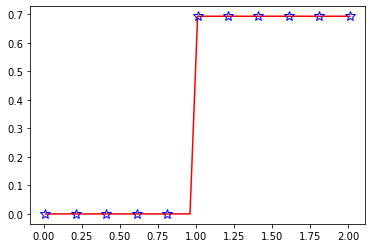

In [17]:
plt.plot(Jlist0,S_ext_Jx,'r-',markersize=8)
plt.plot(Jlist,S_cit_Jx,'b*',markerfacecolor='None',markersize=10)

a='T_exact.npy'
np.save(a,S_ext_Jx)
b='T_sim.npy'
np.save(b,S_cit_Jx)

In [21]:
def obtain_entropycf(joblist,nshots,J):
    result = joblist.result()
    S = np.zeros(len(J))
    for n in range(len(J)):
        cm = np.zeros(2)
        for mo in range(2):
            num = result.get_counts(2*n+mo)
            r=list(num.keys())
            a=list(num.values())
            Num_Sta = np.zeros(2)
            coe = np.zeros(2)
            for j in range(0,len(r)):
                label = [ int(s) for s in r[j] ]
                #print(label)
                lab_state = 0
                for m in range(len(label)):
                    lab_state = lab_state + 2**m*label[m]
                Num_Sta[lab_state] = a[j]/nshots
                coe[lab_state] =(-1)**(label[0])
            cm[mo] = np.dot(coe,Num_Sta)
        S[n] = findS(np.sum(cm)/2*1j)
    return S

def circuit_constructioncf(J,Jz,alpha,k):
    circuits = []
    for njx in range(len(J)):
        Jx = J[njx]
        qc = build_p(Jx,Jz,alpha,k)
        circuits.append(qc)
        qc = build_m(Jx,Jz,alpha,k)
        circuits.append(qc)
    return circuits

In [22]:
Jxlist = np.linspace(0,2,41)
Jzlist = np.linspace(0.001,2.001,41)
alpha = -1
k = 0

nshots=1024*8

AllJobslistc=[]
for iJz,Jz in enumerate(Jzlist):
    qc = circuit_constructioncf(Jxlist,Jz,alpha,k)
    qobj=qiskit.transpile(qc,initial_layout=[0,1,2,3])
    job = qiskit.execute(qobj, backend_sim,shots=nshots)
    AllJobslistc.append(job)
    print(iJz, Jz)

0 0.001
1 0.051000000000000004
2 0.101
3 0.15100000000000002
4 0.201
5 0.251
6 0.30100000000000005
7 0.35100000000000003
8 0.401
9 0.451
10 0.501
11 0.551
12 0.6010000000000001
13 0.651
14 0.7010000000000001
15 0.751
16 0.801
17 0.8510000000000001
18 0.901
19 0.9510000000000001
20 1.001
21 1.051
22 1.101
23 1.151
24 1.201
25 1.251
26 1.301
27 1.351
28 1.401
29 1.451
30 1.501
31 1.551
32 1.601
33 1.651
34 1.701
35 1.751
36 1.801
37 1.851
38 1.901
39 1.951
40 2.001


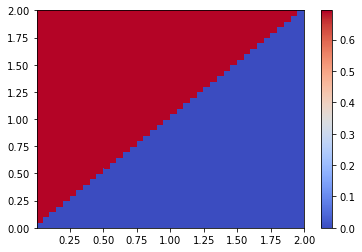

In [23]:
Sc_cf = np.zeros((len(Jxlist),len(Jzlist)))
for nj,J in enumerate(Jzlist):
    joblist = AllJobslistc[nj]
    Sc_cf[:,nj]=obtain_entropycf(joblist,nshots,Jxlist)

JJx,JJz = np.meshgrid(Jxlist,Jzlist)
#S_min, S_max = S.min(), S.max()

from matplotlib import cm
fig, axs = plt.subplots(1, 1)
c = axs.pcolor(JJz, JJx, np.transpose(Sc_cf), cmap=cm.coolwarm)
fig.colorbar(c, ax=axs)

In [24]:
T_mean=np.load('transition_almaden.npy')
T_std=np.load('transition_std_almaden.npy')

S_ph = np.load('S_diagram.npy')

E_gapped1 = np.load('eig_gapped_mean1.npy')
E_gapped2 = np.load('eig_gapped_mean2.npy')
E_gapped_std1 = np.load('eig_gapped_std1.npy')
E_gapped_std2 = np.load('eig_gapped_std2.npy')


E_gapless1 = np.load('eig_gapless_mean1.npy')
E_gapless2 = np.load('eig_gapless_mean2.npy')
E_gapless_std1 = np.load('eig_gapless_std1.npy')
E_gapless_std2 = np.load('eig_gapless_std2.npy')

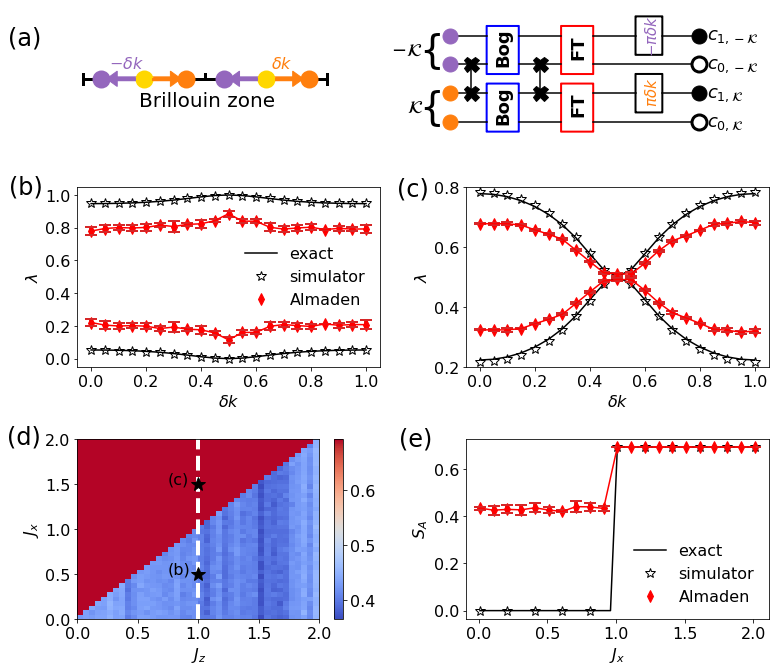

In [35]:
import matplotlib.patches as patches
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(12,10))


ax1 = fig.add_axes([0.1, 0.45, 0.35, 0.25], ylim=(-0.05, 1.05))
ax2 = fig.add_axes([0.55, 0.45, 0.35, 0.25], ylim=(0.2, 0.8))
ax3 = fig.add_axes([0.1, 0.1, 0.35, 0.25], xlim=(0,2))
ax4 = fig.add_axes([0.55, 0.1, 0.35, 0.25])
ax5 = fig.add_axes([0.1, 0.75, 0.8, 0.2],ylim=(-0.15, 0.6),xlim=(-0.1, 1.2))
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.setp(ax1.get_xticklabels(), fontsize=16)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

plt.setp(ax2.get_yticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
ax2.set_yticks([0.2,0.4,0.6,0.8])

plt.setp(ax3.get_yticklabels(), fontsize=16)
plt.setp(ax3.get_xticklabels(), fontsize=16)
ax3.set_xticks([0,0.5,1,1.5,2])
ax3.set_yticks([0,0.5,1,1.5,2])

plt.setp(ax4.get_yticklabels(), fontsize=16)
plt.setp(ax4.get_xticklabels(), fontsize=16)
ax4.set_xticks([0,0.5,1,1.5,2])
ax4.set_yticks([0,0.2,0.4,0.6])

ax5.plot([0.05+0.55,0.12+0.55],[0,0],'k-')
ax5.plot([0.05+0.55,0.12+0.55],[0.15,0.15],'k-')
ax5.plot([0.05+0.55,0.12+0.55],[0.3,0.3],'k-')
ax5.plot([0.05+0.55,0.12+0.55],[0.45,0.45],'k-')
ax5.plot([0.09+0.55],[0.15],'kX',markersize=15)
ax5.plot([0.09+0.55],[0.3],'kX',markersize=15)
ax5.plot([0.09+0.55,0.09+0.55],[0.15,0.3],'k-')
ax5.plot(0.05+0.55,0,'o',markersize=15,color='tab:orange')
ax5.plot(0.05+0.55,0.15,'o',markersize=15,color='tab:orange')
ax5.plot(0.05+0.55,0.3,'o',markersize=15,color='tab:purple')
ax5.plot(0.05+0.55,0.45,'o',markersize=15,color='tab:purple')
fancybox = mpatches.FancyBboxPatch(
    [0.12+0.55, -0.05], 0.06, 0.25,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="b",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.135+0.55, 0.01, r'Bog', fontsize=18,color='k',weight='bold',rotation=90)
fancybox = mpatches.FancyBboxPatch(
    [0.12+0.55, 0.25], 0.06, 0.25,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="b",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.135+0.55, 0.31, r'Bog', fontsize=18,color='k',weight='bold',rotation=90)

ax5.plot([0.18+0.55,0.26+0.55],[0,0],'k-')
ax5.plot([0.18+0.55,0.26+0.55],[0.15,0.15],'k-')
ax5.plot([0.18+0.55,0.26+0.55],[0.3,0.3],'k-')
ax5.plot([0.18+0.55,0.26+0.55],[0.45,0.45],'k-')
ax5.plot([0.22+0.55],[0.15],'kX',markersize=15)
ax5.plot([0.22+0.55],[0.3],'kX',markersize=15)
ax5.plot([0.22+0.55,0.22+0.55],[0.15,0.3],'k-')

fancybox = mpatches.FancyBboxPatch(
    [0.26+0.55, -0.05], 0.06, 0.25,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="r",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.275+0.55, 0.05, r'FT', fontsize=18,color='k',weight='bold',rotation=90)
fancybox = mpatches.FancyBboxPatch(
    [0.26+0.55, 0.25], 0.06, 0.25,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="r",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.275+0.55, 0.35, r'FT', fontsize=18,color='k',weight='bold',rotation=90)

ax5.plot([0.32+0.55,0.52+0.55],[0,0],'k-')
ax5.plot([0.32+0.55,0.4+0.55],[0.15,0.15],'k-')
ax5.plot([0.32+0.55,0.52+0.55],[0.3,0.3],'k-')
ax5.plot([0.32+0.55,0.4+0.55],[0.45,0.45],'k-')
fancybox = mpatches.FancyBboxPatch(
    [0.4+0.55, 0.05], 0.05, 0.2,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="k",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.415+0.55, 0.1, r'$\pi \delta k$', fontsize=15,color='tab:orange',weight='bold',rotation=90)

fancybox = mpatches.FancyBboxPatch(
    [0.4+0.55, 0.35], 0.05, 0.2,
    boxstyle=mpatches.BoxStyle("Round", pad=0.0002),color='none',ec="k",linewidth=2)
ax5.add_patch(fancybox)
plt.text(0.415+0.55, 0.36, r'$-\pi \delta k$', fontsize=15,color='tab:purple',weight='bold',rotation=90)

ax5.plot([0.45+0.55,0.52+0.55],[0.15,0.15],'k-')
ax5.plot([0.45+0.55,0.52+0.55],[0.45,0.45],'k-')

ax5.plot(0.52+0.55,0,'ko',markerfacecolor='w',markersize=15,markeredgewidth=3)
ax5.plot(0.52+0.55,0.15,'ko',markersize=15)
ax5.plot(0.52+0.55,0.3,'ko',markerfacecolor='w',markersize=15,markeredgewidth=3)
ax5.plot(0.52+0.55,0.45,'ko',markersize=15)

ax5.text(0.535+0.55, -0.02, r'$c_{0,\mathcal{K}}$',fontsize=18)
ax5.text(0.535+0.55, 0.13, r'$c_{1,\mathcal{K}}$',fontsize=18)
ax5.text(0.535+0.55, 0.28, r'$c_{0,-\mathcal{K}}$',fontsize=18)
ax5.text(0.535+0.55, 0.43, r'$c_{1,-\mathcal{K}}$',fontsize=18)

ax5.annotate(r"$\{$",fontsize=39,
            xy=(0.54, 0.821), xycoords='figure fraction'
            )

ax5.annotate(r"$\{$",fontsize=39,
            xy=(0.54, 0.906), xycoords='figure fraction'
            )

ax5.text(-0.03+0.55, 0.05, r'$\mathcal{K}$',fontsize=18)
ax5.text(-0.06+0.55, 0.35, r'$-\mathcal{K}$',fontsize=18)


ax5.plot([-0.04-0.05,0.42-0.05],[0.225,0.225],'k-',linewidth=3)
ax5.plot([-0.04-0.05,-0.04-0.05],[0.2,0.25],'k-',linewidth=3)
ax5.plot([0.42-0.05,0.42-0.05],[0.2,0.25],'k-',linewidth=3)
ax5.plot([0.19-0.05,0.19-0.05],[0.225,0.25],'k-',linewidth=3)

ax5.plot(0.075-0.05,0.225,'o',color='gold',markerfacecolor='gold',markersize=15,markeredgewidth=3)
ax5.plot(0.075+0.23-0.05,0.225,'o',color='gold',markerfacecolor='gold',markersize=15,markeredgewidth=3)

ax5.plot(0.075+0.08-0.05,0.225,'o',color='tab:orange',markerfacecolor='tab:orange',markersize=15,markeredgewidth=3)
ax5.plot(0.075+0.23+0.08-0.05,0.225,'o',color='tab:orange',markerfacecolor='tab:orange',markersize=15,markeredgewidth=3)

ax5.plot(0.075-0.08-0.05,0.225,'o',color='tab:purple',markerfacecolor='tab:purple',markersize=15,markeredgewidth=3)
ax5.plot(0.075+0.23-0.08-0.05,0.225,'o',color='tab:purple',markerfacecolor='tab:purple',markersize=15,markeredgewidth=3)


ax5.arrow(0.075-0.05,0.225,0.07,0,length_includes_head=True, width=0.02, head_width=0.08,head_length=0.02,fc='tab:orange', ec='tab:orange')

ax5.plot([0.093-0.05,0.093+0.043-0.05],[0.225,0.225],'-',linewidth=3,color='tab:orange')

ax5.arrow(0.075+0.23-0.05,0.225,0.07,0,length_includes_head=True, width=0.02, head_width=0.08,head_length=0.02,fc='tab:orange', ec='tab:orange')

ax5.plot([0.0945+0.23-0.05,0.093+0.043+0.23-0.05],[0.225,0.225],'-',linewidth=3,color='tab:orange')

ax5.arrow(0.075-0.05,0.225,-0.07,0,length_includes_head=True, width=0.02, head_width=0.08,head_length=0.02,fc='tab:purple', ec='tab:purple')

ax5.plot([0.056-0.05,0.057-0.043-0.05],[0.225,0.225],'-',linewidth=3,color='tab:purple')

ax5.arrow(0.075+0.23-0.05,0.225,-0.07,0,length_includes_head=True, width=0.02, head_width=0.08,head_length=0.02,fc='tab:purple', ec='tab:purple')

ax5.plot([0.056+0.23-0.05,0.057-0.043+0.23-0.05],[0.225,0.225],'-',linewidth=3,color='tab:purple')

ax5.text(0.085+0.23-0.05,0.28,r'$\delta k$',color='tab:orange',fontsize=16)

ax5.text(0.02-0.06,0.28,r'$-\delta k$',color='tab:purple',fontsize=16)

ax5.text(0.065-0.05,0.08,r'Brillouin zone',color='k',fontsize=20)

ax5.text(-0.23,0.4,'(a)',fontsize=24)

ax5.axis('off')

ax1.plot(klist+0.5,Eeig_ext_pk[0,:],'k-',markersize=8,label="exact")
ax1.plot(klist+0.5,Eeig_ext_pk[1,:],'k-')
ax1.plot(klist+0.5,Eeig_cit_pk[0,:],'k*',markerfacecolor='None',markersize=10,label="simulator")
ax1.plot(klist+0.5,Eeig_cit_pk[1,:],'k*',markerfacecolor='None',markersize=10)
ax1.plot(klist+0.5,E_gapped1,'d',color='r',markersize=8,label="Almaden")
ax1.errorbar(klist+0.5, E_gapped1, E_gapped_std1,fmt='r-',capsize=6, elinewidth=4,capthick=2,ecolor='tab:red')
ax1.plot(klist+0.5,E_gapped2,'d',color='r',markersize=8)
ax1.errorbar(klist+0.5, E_gapped2, E_gapped_std2,fmt='r-',capsize=6, elinewidth=4,capthick=2,ecolor='tab:red')
ax1.legend(bbox_to_anchor=(1, 0.75), ncol=1, loc='upper right', frameon=False, fontsize=16)
ax1.text(-0.3,1.01,'(b)',fontsize=24)
ax1.set_ylabel(r'$\lambda$',fontsize=16)
ax1.set_xlabel(r'$\delta k$',fontsize=16)

ax2.plot(klist+0.5,np.transpose(Eeig_ext_mk),'k-',markersize=8)
ax2.plot(klist+0.5,np.transpose(Eeig_cit_mk),'k*',markerfacecolor='None',markersize=10)
ax2.plot(klist+0.5,E_gapless1,'d',color='r',markersize=8,label="Almaden")
ax2.errorbar(klist+0.5, E_gapless1, E_gapless_std1,fmt='r-',capsize=6, elinewidth=4,capthick=2,ecolor='tab:red')
ax2.plot(klist+0.5,E_gapless2,'d',color='r',markersize=8)
ax2.errorbar(klist+0.5, E_gapless2, E_gapless_std2,fmt='r-',capsize=6, elinewidth=4,capthick=2,ecolor='tab:red')
ax2.text(-0.3,0.77,'(c)',fontsize=24)
ax2.set_ylabel(r'$\lambda$',fontsize=16)
ax2.set_xlabel(r'$\delta k$',fontsize=16)

c = ax3.pcolor(JJz, JJx, np.transpose(S_ph), cmap=cm.coolwarm)
ax3.plot([1,1],[0,2],'w--',Linewidth=4)
ax3.plot([1],[0.5],'*',markersize=15,color='k')
ax3.text(0.75,0.5,r'(b)',fontsize=16)
ax3.plot([1],[1.5],'*',markersize=15,color='k')
ax3.text(0.75,1.5,r'(c)',fontsize=16)
cbar = fig.colorbar(c, ax=ax3,ticks=[0.4, 0.5, 0.6])
cbar.ax.set_yticklabels(['0.4', '0.5', '0.6'])
cbar.ax.tick_params(labelsize=16)
ax3.text(-0.58,1.95,'(d)',fontsize=24)
ax3.set_ylabel(r'$J_x$',fontsize=16)
ax3.set_xlabel(r'$J_z$',fontsize=16)

JlistT = np.linspace(0.01,2.01,21)

ax4.plot(Jlist0,S_ext_Jx,'k-',markersize=8,label='exact')
ax4.plot(Jlist,S_cit_Jx,'k*',markerfacecolor='None',markersize=10,label='simulator')
ax4.plot(JlistT,T_mean,'d',color='r',markersize=8,label='Almaden')
ax4.errorbar(JlistT, T_mean, T_std,fmt='r-',capsize=6, elinewidth=4,capthick=2,ecolor='tab:red')

ax4.legend(bbox_to_anchor=(1, 0.5), ncol=1, loc='upper right', frameon=False, fontsize=16)
ax4.text(-0.58,0.7,'(e)',fontsize=24)
ax4.set_ylabel(r'$S_A$',fontsize=16)
ax4.set_xlabel(r'$J_x$',fontsize=16)

plt.savefig('Fig5.pdf', bbox_inches='tight')